In [1]:
import pandas as pd
import numpy as np
from numpy.random import SeedSequence
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.signal import detrend
from Modules import EDM as ccm
from pyEDM import *
from matplotlib.patches import Patch
#https://stats.stackexchange.com/questions/204032/surrogate-time-series-using-fourier-transform

In [2]:
plt.rcParams.update({
    'font.size': 15,
    "lines.linewidth": 1.5,
    "font.family": "arial",
    # "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm": "arial",
})

In [3]:
def dt(data):
    deterended_data = np.zeros(data.shape)
    for i in range(data.shape[0]):
        deterended_data[i] =  detrend(data[i], type='constant')
    return deterended_data

In [4]:
df = pd.read_csv("Data/Cleaned_df_386.csv").drop(columns = ["Unnamed: 0"])
df['Date'] = pd.to_datetime(df['Date'])
Rosters = df["Roster_ID"].unique()
df_1 = df[df["Roster_ID"]==Rosters[1]]
dates = df_1["Date"]
T = len(df_1)
N = len(Rosters)

All_Jails_pop = np.zeros([len(Rosters),T])
All_Cases = np.zeros([len(Rosters),T])

for i, Roster in enumerate(Rosters):
    l_df = df[df["Roster_ID"]==Roster]
    J = l_df["Population_Interpolated"].values
    C = l_df["Cases"].values
    All_Jails_pop[i] = J   
    All_Cases[i] = C
Js = dt(All_Jails_pop)
Cs = dt(All_Cases)

Js_mean = np.mean(Js, axis = 0)
Cs_mean = np.mean(Cs, axis = 0)
df = pd.DataFrame({"J":Js_mean, "C":Cs_mean})

taw_results =  []
for taw in range(1,5):
    re = EmbedDimension( dataFrame = df, lib = "1 104", pred = "1 104",
                    columns = "J", target = "J", tau = taw, maxE = 10, showPlot = False)
    re["taw"] = "Tau={}".format(taw)
    taw_results.append(re)
final_re = pd.concat(taw_results)
final_re.sort_values(by="rho", ascending = False).iloc[0]
taw_opt_J = int(final_re.sort_values(by="rho", ascending = False).iloc[0].taw.split("=")[-1])
E_opt_J = final_re.sort_values(by="rho", ascending = False).iloc[0].E

taw_results =  []
for taw in range(1,5):
    re = EmbedDimension( dataFrame = df, lib = "1 104", pred = "1 104",
                    columns = "C", target = "C", tau = taw, maxE = 10, showPlot = False)
    re["taw"] = "Tau={}".format(taw)
    taw_results.append(re)
final_re = pd.concat(taw_results)
taw_opt_C = int(final_re.sort_values(by="rho", ascending = False).iloc[0].taw.split("=")[-1])
E_opt_C = final_re.sort_values(by="rho", ascending = False).iloc[0].E

J = Js_mean
C = Cs_mean

In [5]:
surro_sample = 3 ## This is 10,000 in the original results
df_P_hat_K_V, _ = ccm.Get_CCM_Plot_df(
                      source = J,
                      target = C,
                      nsamp = 3, m_source=E_opt_J, m_target=E_opt_C, ## This is 5 in the original results
                      tau_source=taw_opt_J, tau_target=taw_opt_C)

df_V_hat_K_P, _ = ccm.Get_CCM_Plot_df(
                      source = C,
                      target = J,
                      nsamp = 3, m_source=E_opt_C, m_target=E_opt_J, ## This is 5 in the original results
                      tau_source=taw_opt_C, tau_target=taw_opt_J)

block_size = 15
C_blocks = C.copy().reshape(-1, block_size)
J_blocks = J.copy().reshape(-1, block_size)

V_hat_K_P_Surrogates = []
for _ in range(surro_sample):
    np.random.shuffle(C_blocks)
    df_V_hat_K_P_surr, _ = ccm.Get_CCM_Plot_df(
                      source = C_blocks.reshape(-1),
                      target = J,
                      nsamp = 1, m_source=E_opt_C, m_target=E_opt_J,
                      tau_source=taw_opt_C, tau_target=taw_opt_J)
    V_hat_K_P_Surrogates.append(df_V_hat_K_P_surr)
df_V_hat_K_P_Surrogates =  pd.concat(V_hat_K_P_Surrogates, ignore_index=True)

P_hat_K_V_Surrogates = []
for _ in range(surro_sample):
    np.random.shuffle(J_blocks)
    df_P_hat_K_V_surr, _ = ccm.Get_CCM_Plot_df(
                      source = J_blocks.reshape(-1),
                      target = C,
                      nsamp = 1, m_source=E_opt_J, m_target=E_opt_C,
                      tau_source=taw_opt_J, tau_target=taw_opt_C)
    P_hat_K_V_Surrogates.append(df_P_hat_K_V_surr)
df_P_hat_K_V_Surrogates =  pd.concat(P_hat_K_V_Surrogates, ignore_index=True)

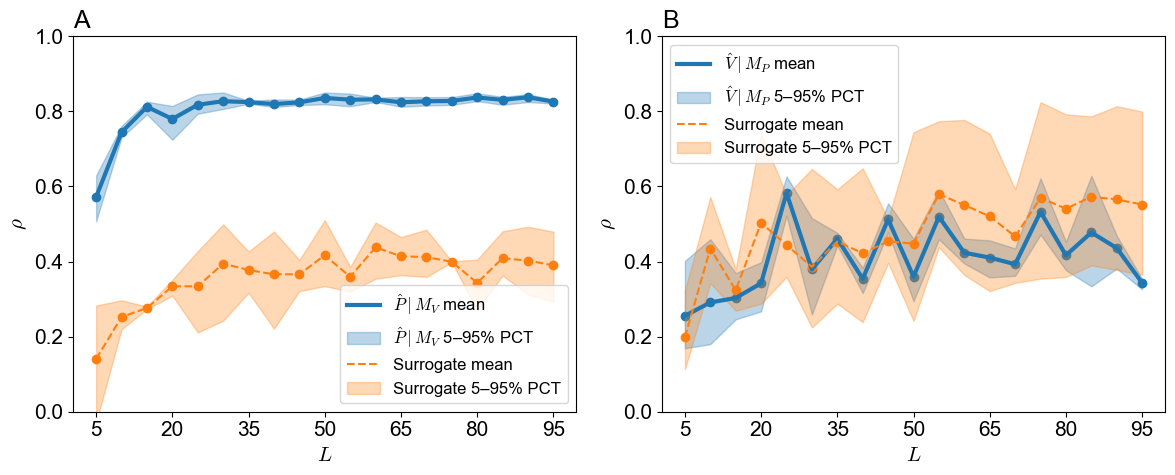

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

ccm.CCM_plot(df_P_hat_K_V, df_P_hat_K_V_Surrogates, "P", "V", "A", ax=axs[0])
ccm.CCM_plot(df_V_hat_K_P, df_V_hat_K_P_Surrogates, "V", "P", "B", ax=axs[1])

plt.tight_layout()
# plt.savefig("Results/CCM_Pval.pdf", bbox_inches="tight")
plt.show()

In [7]:
## Save data to plot and proccess later

# df_P_hat_K_V.to_csv("Solutions/df_P_hat_K_V_permutate.csv", index=False)
# df_V_hat_K_P.to_csv("Solutions/df_V_hat_K_P_permutate.csv", index=False)
# df_P_hat_K_V_Surrogates.to_csv("Solutions/df_P_hat_K_V_Surrogates_permutate.csv", index=False)
# df_V_hat_K_P_Surrogates.to_csv("Solutions/df_V_hat_K_P_Surrogates_permutate.csv", index=False)